<a href="https://colab.research.google.com/github/Bibhash123/Project-Primary-Quantization/blob/main/experiments/Primary_Quantization_Tondi's_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/andreacos/CnnJpegPrimaryQuantizationEstimation.git

Cloning into 'CnnJpegPrimaryQuantizationEstimation'...
remote: Enumerating objects: 459, done.
remote: Counting objects: 100% (459/459), done.
remote: Compressing objects: 100% (412/412), done.
remote: Total 459 (delta 40), reused 430 (delta 26), pack-reused 0
Receiving objects: 100% (459/459), 11.67 MiB | 16.99 MiB/s, done.
Resolving deltas: 100% (40/40), done.


In [ ]:
from google.colab import files
_ = files.upload()
!mkdir ~/.kaggle/
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!pip install -q kaggle
# !kaggle datasets download -d "bibhash123/firstquantest"
# !unzip -q firstquantest.zip -d "/content/Data/"
# !rm -r firstquantest.zip
!kaggle datasets download -d "bibhash123/tondidataset"
!unzip -q tondidataset.zip -d "/content/Data/"
!rm -r tondidataset.zip

Saving kaggle.json to kaggle.json
 99% 575M/581M [00:06<00:00, 126MB/s]
100% 581M/581M [00:06<00:00, 93.8MB/s]


In [ ]:
import os
import gc
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from functools import partial
import matplotlib.pyplot as plt
from keras.models import load_model
sns.set_style('darkgrid')

In [ ]:
def preprocess_input(im_file, target_size, scale=255.):
    """ 
        Read image and (eventually) scale data
        Arguments:
            im_file     : input image file
            target_size : output size of the image (height, width)
            scale       : pixel scaling value
        Returns: The image
    """
    file_bytes = tf.io.read_file(im_file)
    img = tf.image.decode_png(file_bytes, channels = 0)
    # Normalize and Resize
    if img.shape != target_size:
        img = tf.image.resize(img, target_size)
    img = tf.cast(img/255.0, tf.float32)
    return img

In [ ]:
def string2Q(s, size=(8, 8), flatten=True):
    """ Converts a comma separated string to a matrix.
        Keyword arguments:
        sq : input string
        size : output matrix size
    """
    if flatten:
        return tf.strings.to_number(tf.strings.split(s,','),out_type=tf.int32)
    else:
        return tf.reshape(tf.strings.to_number(tf.strings.split(s,','),out_type=tf.int32),size)

In [ ]:
def get_label(im_label):
    return string2Q(im_label)[:15]

In [ ]:
files = pd.read_csv("/content/Data/test.csv",sep=";",header=None,
                         names=['idx', 'filenames', 'quality1', 'quality2', 'software', 'labels',
                                'shift_r', 'shift_c']
                         )

files.head()

,idx,filenames,quality1,quality2,software,labels,shift_r,shift_c
0,0,/content/Data/Test/95-90/00000000_r12c5f70bt.T...,95,90,python-opencv,"2,1,1,1,1,1,2,1,1,1,2,2,2,2,2,4,3,2,2,2,2,5,4,...",5,4
1,1,/content/Data/Test/95-90/00000001_r12c5f70bt.T...,95,90,python-opencv,"2,1,1,1,1,1,2,1,1,1,2,2,2,2,2,4,3,2,2,2,2,5,4,...",5,4
2,2,/content/Data/Test/95-90/00000002_r12c5f70bt.T...,95,90,python-opencv,"2,1,1,1,1,1,2,1,1,1,2,2,2,2,2,4,3,2,2,2,2,5,4,...",5,4
3,3,/content/Data/Test/95-90/00000003_r12c5f70bt.T...,95,90,python-opencv,"2,1,1,1,1,1,2,1,1,1,2,2,2,2,2,4,3,2,2,2,2,5,4,...",5,4
4,4,/content/Data/Test/95-90/00000004_r12c5f70bt.T...,95,90,python-opencv,"2,1,1,1,1,1,2,1,1,1,2,2,2,2,2,4,3,2,2,2,2,5,4,...",5,4


In [ ]:
files['quality1'].unique()

array([95, 90, 75, 60, 70, 80, 85, 98, 65])

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

def build_decoder(is_labelled):
  def if_labelled(path,label,target_size):
    image = preprocess_input(path,target_size)
    label = get_label(label)
    return image,label
  
  return if_labelled if is_labelled else preprocess_input

def create_dataset(df, batch_size = 32, is_labelled = False, repeat = False, shuffle = False, batch=False, cache=False):
    decode_fn = build_decoder(is_labelled)
    
    # Create Dataset
    if is_labelled:
        dataset = tf.data.Dataset.from_tensor_slices((df['filenames'].values,df["labels"].values))
    else:
        dataset = tf.data.Dataset.from_tensor_slices((df['filenames'].values))

    dataset = dataset.map(partial(decode_fn,target_size=(64,64)), num_parallel_calls = AUTOTUNE)
    dataset = dataset.cache("") if cache else dataset
    dataset = dataset.repeat() if repeat else dataset
    dataset = dataset.shuffle(1024, reshuffle_each_iteration = True) if shuffle else dataset
    dataset = dataset.batch(batch_size,drop_remainder=True) if batch else dataset
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [ ]:
def getX(X,Y):
  return X
def getY(X,Y):
  return Y

In [ ]:
test_set = create_dataset(files, 
                          batch_size = 32, is_labelled = True, repeat = False, shuffle = False, batch=True,cache=False)
Y = test_set.map(getY)
model = load_model('/content/CnnJpegPrimaryQuantizationEstimation/models/pre_trained/DNN90_60LOG.h5')
model.compile(loss='mse',optimizer='adam')

In [ ]:
pred = model.predict(test_set)
pred.shape

(53984, 15)

In [ ]:
y = np.array(list(Y.unbatch().as_numpy_iterator()))
y.shape

(53984, 15)

In [ ]:
print("Accuracy = {:.4f}".format(np.count_nonzero(np.round(pred)==y)/(15*y.shape[0])))
print("RMSE = {:.4f}".format(np.sum(np.square(y - pred)) / (y.shape[0]*15)))

Accuracy = 0.7036
RMSE = 0.7278


--------------------------------------------------------------------------------
Quality Factors QF1,QF2: 60,90
Accuracy:  0.5585004456327985
MSE:  1.5452328604808738
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Quality Factors QF1,QF2: 65,90
Accuracy:  0.5547125668449198
MSE:  1.1545590257111824
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Quality Factors QF1,QF2: 70,90
Accuracy:  0.610204991087344
MSE:  0.7084496817596582
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Quality Factors QF1,QF2: 75,90
Accuracy:  0.7324420677361854
MSE:  0.4360028186987518
--------------------------------------------------------------------------------
---------

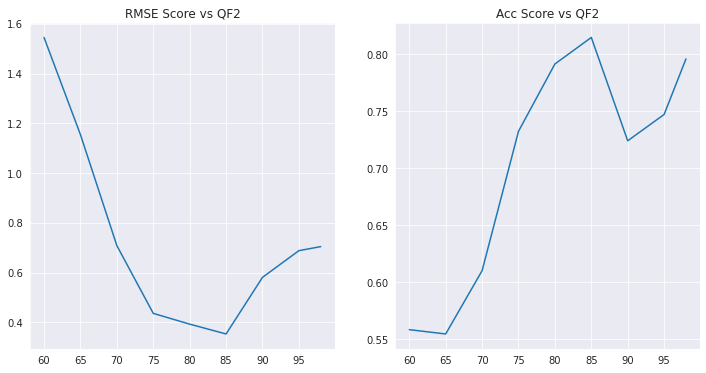

In [ ]:
mses = []
accs = []
QF1 = [60, 65, 70, 75, 80, 85, 90, 95, 98]
for qf1 in QF1:
  test_sample = files[(files["quality2"]==90)&(files["quality1"]==qf1)]
  test_set = create_dataset(test_sample, 
                            batch_size = 32, is_labelled = True, repeat = False, shuffle = False, batch=True,cache=False)
  Y = test_set.map(getY)
  model = load_model('/content/CnnJpegPrimaryQuantizationEstimation/models/pre_trained/DNN90_60LOG.h5')
  model.compile(loss='mse',optimizer='adam')

  pred = model.predict(test_set)
  y = np.array(list(Y.unbatch().as_numpy_iterator()))

  mse = np.sum(np.square(y - pred)) / (y.shape[0]*15)
  acc = np.count_nonzero(np.round(pred)==y)/(15*y.shape[0])
  mses.append(mse)
  accs.append(acc)

  print("-"*80)
  print("Quality Factors QF1,QF2: {},{}".format(qf1,90))
  print("Accuracy: ",acc)
  print("MSE: ",mse)
  print("-"*80)

fig,ax = plt.subplots(1,2,figsize=(12,6))
sns.lineplot(x=QF1,y=mses,ax = ax[0])
ax[0].set_title('RMSE Score vs QF2');
sns.lineplot(x=QF1,y=accs,ax = ax[1])
ax[1].set_title('Acc Score vs QF2');

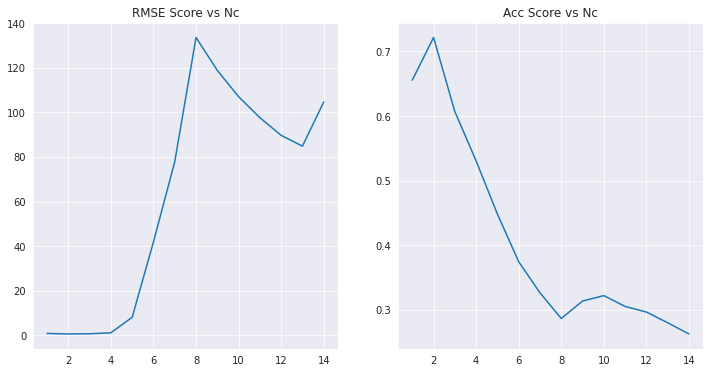

In [ ]:
rmse = []
acc = []
for nc in range(1,15,1):
  rmse.append(np.sum(np.square(y[:,:nc] - pred[:,:nc])) / (y.shape[0]*nc))
  acc.append(np.count_nonzero(np.round(pred[:,:nc])==y[:,:nc])/(nc*y.shape[0]))
fig,ax = plt.subplots(1,2,figsize=(12,6))
sns.lineplot(x=range(1,15,1),y=rmse,ax = ax[0])
ax[0].set_title('RMSE Score vs Nc');
sns.lineplot(x=range(1,15,1),y=acc,ax = ax[1])
ax[1].set_title('Acc Score vs Nc');

In [ ]:
pd.DataFrame.from_dict({'QF1':QF1,'RMSE':rmse,'Accuracy':acc})

,QF1,RMSE,Accuracy
0,60,339.405214,0.153621
1,65,259.617519,0.132018
2,70,190.953436,0.135228
3,75,128.359831,0.126437
4,80,78.038996,0.242841
5,85,43.756362,0.243410
6,90,21.417436,0.233551
7,95,5.333797,0.351220
8,98,0.876562,0.607598


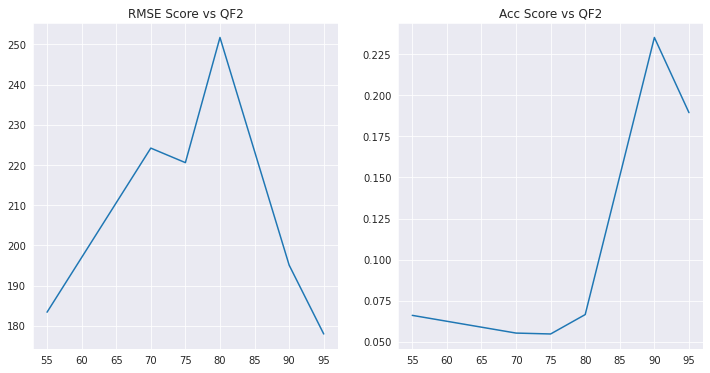

In [ ]:
rmse = []
acc = []
for qf2 in files["QF2"].unique():
  test_sample = files[files["QF2"]==qf2]
  test_set = create_dataset(test_sample, 
                            batch_size = 32, is_labelled = True, repeat = False, shuffle = False, batch=True,cache=False)
  Y = test_set.map(getY)
  model = load_model('/content/CnnJpegPrimaryQuantizationEstimation/models/pre_trained/DNN90_60LOG.h5')
  model.compile(loss='mse',optimizer='adam')

  pred = model.predict(test_set)
  y = np.array(list(Y.unbatch().as_numpy_iterator()))

  rmse.append(np.sum(np.square(y - pred)) / (y.shape[0]*15))
  acc.append(np.count_nonzero(np.round(pred)==y)/(15*y.shape[0]))

fig,ax = plt.subplots(1,2,figsize=(12,6))
sns.lineplot(x=files["QF2"].unique(),y=rmse,ax = ax[0])
ax[0].set_title('RMSE Score vs QF2');
sns.lineplot(x=files["QF2"].unique(),y=acc,ax = ax[1])
ax[1].set_title('Acc Score vs QF2');

In [ ]:
np.round(pred)

array([[14., 10., 11., ..., 14., 17., 22.],
       [14., 10., 11., ..., 14., 17., 23.],
       [14., 10., 11., ..., 14., 17., 22.],
       ...,
       [ 2.,  1.,  1., ...,  2.,  2.,  2.],
       [ 2.,  1.,  1., ...,  2.,  3.,  3.],
       [ 3.,  2.,  2., ...,  3.,  4.,  4.]], dtype=float32)

In [ ]:
y

array([[16, 11, 10, ..., 26, 58, 60],
       [16, 11, 10, ..., 26, 58, 60],
       [16, 11, 10, ..., 26, 58, 60],
       ...,
       [ 1,  1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ...,  1,  1,  1]], dtype=int32)

In [ ]:
!nvidia-smi

Sun Dec  5 18:02:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0    74W / 149W |   2329MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv("/content/Benchmarking.csv")

In [ ]:
data['Proposed Method'] = data['Final Result']

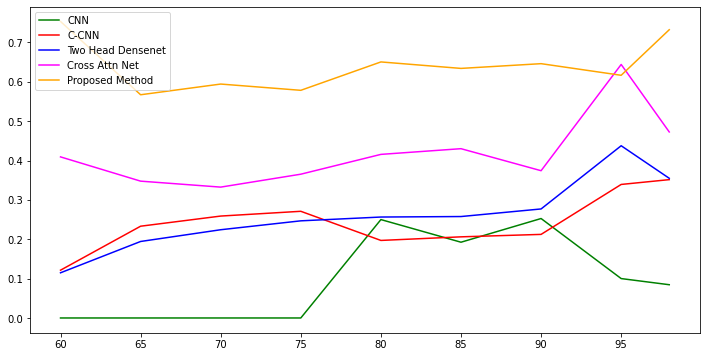

In [ ]:
methods = ['CNN','C-CNN','Two Head Densenet','Cross Attn Net','Proposed Method']
color = ['green','red','blue','magenta','orange']
qfs = [60,65,70,75,80,85,90,95,98]
plt.figure(figsize = (12,6))
for idx,method in enumerate(methods):
  plt.plot(qfs, data[method],c=color[idx],label=method)
plt.legend()
plt.savefig('benchmarking.pdf')
plt.show()

In [ ]:
methods = ['Niu et al','C-CNN','Two Head Densenet','Cross Attn Net','Proposed Method']
color = ['green','red','blue','magenta','orange']
qfs = [60,65,70,75,80,85,90,95,98]
plt.figure(figsize = (12,6))
for idx,method in enumerate(methods):
  plt.plot(qfs, data[method],c=color[idx],label=method)
plt.legend()
plt.savefig('benchmarking.pdf')
plt.show()

In [ ]:
p = pd.read_csv("performance.csv")
p

,Niu et al,Bianchi & Piva,Proposed
0,0.558622,0.375,0.753389
1,0.555100,0.395,0.567178
2,0.610744,0.370,0.594356
3,0.732622,0.295,0.578456
4,0.791900,0.215,0.650567
5,0.814822,0.115,0.634122
6,0.724700,0.040,0.646156
7,0.747667,0.090,0.616633
8,0.796411,0.040,0.732378


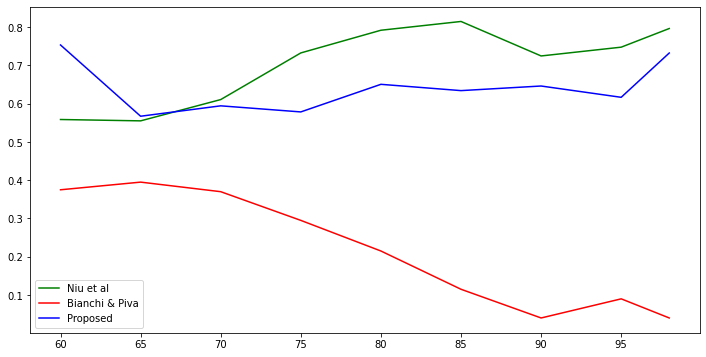

In [ ]:
methods = ['Niu et al','Bianchi & Piva','Proposed']
color = ['green','red','blue']
qfs = [60,65,70,75,80,85,90,95,98]
plt.figure(figsize = (12,6))
for idx,method in enumerate(methods):
  plt.plot(qfs, p[method],c=color[idx],label=method)
plt.legend()
plt.savefig('benchmarking.pdf')
plt.show()